In [1]:
#general explore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', None)

In [2]:
#cluster imports
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

## Modeling specific fires and surrounding AQ sensors
Aggregate model results, see if trend
Model prescribed vs wildfire separately - what are differences in AQ impact?

#### Step 1: General feature engineering
* overall_aqi = product of individual pollutant aqi_scores (based on EPA Level of Concern classes)
* square overall_aqi and smoke_score to add weight to 1-unit change
* add fire presence/absence col: fire = present (1) from ignition day _t_ to _t_+7
    * Must subset by REGION, instead of whole df. Otherwise you indicate Yes presence of fire in Oregon when there's a 200 acre burn southeast Arizona.
    * Implement KMeans clustering to find proximity-based clusters that are wider and less arbitrary than feature county_name
    * Have yes_fire only positive if fire in that cluster
    * if time, manually pick out large fires with known containment dates and customize this window appropriately


#### Next steps: choose individual fires or regions to model
* ideally find events in proximity of AQ censors.  see tableau visuals to find clusters.
* events with as much data as possible (filter nulls)
* start with 3x3 wild v. rx
* or southern AZ in general has a slew of wild + prescribed burns, and participates in AQ monitoring

In [3]:
motherload = pd.read_csv('../../scratch_data/merges/matched_smoke_fire_pollution_CORRECT.csv')

In [4]:
motherload.dtypes

state                       object
city                        object
county_name                 object
date                         int64
incid_type                  object
burnbndac                  float64
smoke_score                float64
no2_max_ppb                float64
no2_aqi_label               object
o3_max_ppb                 float64
o3_aqi_label                object
so2_max_ppb                float64
so2_aqi_label               object
co_max_ppm                 float64
co_aqi_label                object
incid_name                  object
event_id                    object
burnbndlat                 float64
burnbndlon                 float64
lat_smo                    float64
lon_smo                    float64
aqi_address                 object
geometry_wf                 object
reverse_geocode_fire_ig     object
dtype: object

In [5]:
fmt='%Y%m%d'
motherload['date'] = pd.to_datetime(motherload['date'], format=fmt)

In [6]:
motherload.drop(columns=['geometry_wf', 'reverse_geocode_fire_ig', #burnbndlat, burnbndlon
               'aqi_address', 'city'], inplace=True)

In [7]:
#impute nulls: days where no fires --> 0 acres burned, firetype: No_fire
motherload.fillna({'burnbndac':0, 'incid_type':'No_fire'}, inplace=True)

In [8]:
overall_aqi_dict = {'good':1, 'moderate':2, 'unhealthy for at-risk':4, 'unhealthy': 4,
                   'very unhealthy':5, 'hazardous':5, 0:0}

poll_cols = ['no2_aqi_label', 'o3_aqi_label', 'so2_aqi_label', 'co_aqi_label']
poll = ['no2', 'o3', 'so2', 'co']
zipper = list(zip(poll_cols, poll))

In [9]:
for i in poll_cols:
    motherload[i] = motherload[i].fillna(0)

In [10]:
for i,j in zipper:
    motherload[j+'_aqi_num'] = motherload[i].map(overall_aqi_dict)

motherload['overall_aqi'] = motherload['no2_aqi_num'] * motherload['so2_aqi_num'] * motherload['o3_aqi_num'] * motherload['co_aqi_num']

In [11]:
# square individ_aqis, overall_aqi, & smoke_score for modeling
# add weight to '1-unit' change
def sqr(x):
    return x*x
motherload[['overall_aqi','no2_aqi_num', 'so2_aqi_num', 
            'o3_aqi_num', 'co_aqi_num', 'smoke_score']] = motherload[['overall_aqi',
                                                                      'no2_aqi_num', 'so2_aqi_num', 
                                                                      'o3_aqi_num', 'co_aqi_num', 
                                                                      'smoke_score']].apply(sqr)

## KMeans on all data to generate clusters that are more related than county?
County lines are arbitrary, would rather have some other proximity-based class even if less granular: want to capture AQI sensors in neighboring counties to fire ignition without having to look up which counties are nearby.  
* KMeans sounds appropriate because we want to classify everything (DBSCAN will yield 'outliers' in rural areas). Wildfire often start in very rural areas, but still impact air quality miles away. Don't want those geographically isolated points to be unclassified - still want them mapped to _nearest_ AQI sensors, wherever those may be.

In [12]:
motherload['any_lat'] = motherload['lat_smo'].fillna(motherload['burnbndlat'])
motherload['any_lon'] = motherload['lon_smo'].fillna(motherload['burnbndlon'])

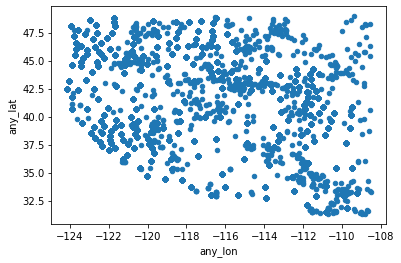

In [13]:
motherload.plot(kind = 'scatter', x='any_lon', y = 'any_lat'); #oof.  try 20?

In [14]:
len(motherload['county_name'].unique())

248

In [15]:
#already standardized scale (all in decimal degrees)
X = motherload[['any_lon', 'any_lat']]
km = KMeans(n_clusters=32, random_state=42)  #settled on 32 after trial and error
km.fit(X)

KMeans(n_clusters=32, random_state=42)

In [16]:
silhouette_score(X, km.labels_) #meh

0.47002997807001584

In [17]:
motherload['cluster'] = km.labels_.astype('object')

In [17]:
centroids = pd.DataFrame(km.cluster_centers_, columns=['any_lon', 'any_lat'])
centroids

,any_lon,any_lat
0,-118.270062,41.438174
1,-115.950378,33.332088
2,-122.708868,45.754374
3,-114.229355,43.058112
4,-121.766189,37.978105
5,-118.942230,45.610672
6,-113.342469,37.415980
7,-110.374793,32.658249
8,-123.469054,41.391457
9,-119.691169,36.861693


In [24]:
# #export centroids df for tableau mapping
# centroids_for_export = centroids.reset_index(drop=False)
# centroids_for_export.rename(columns={'index':'cluster', 'any_lon':'longitude', 
#                                      'any_lat':'latitude'}, inplace=True)
# centroids_for_export.to_csv('./centroids.csv', index=False)

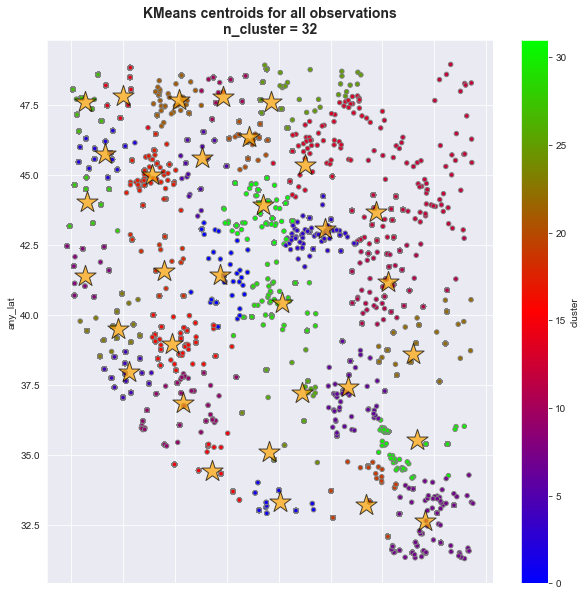

In [19]:
N = 32
# color_labs = motherload['cluster'].unique()
# col_from_palette = sns.color_palette('Dark2', n_clusters)
# cmap = dict(zip(color_labs, col_from_palette))
sns.set_style('darkgrid')
# # define the colormap
cmap = plt.cm.brg
# extract color
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# above code from https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

ax = motherload.plot(kind = 'scatter', x='any_lon', y = 'any_lat', 
                    figsize=(10,10), c = 'cluster', edgecolor='grey', cmap=cmap)

centroids.plot(x='any_lon', y='any_lat', marker='*', c='orange', alpha=.7,
               kind = 'scatter', s=500, edgecolor='black', ax = ax);
plt.title('KMeans centroids for all observations\nn_cluster = 32', size=14, fontweight='bold');

## Check against DBSCAN
## Conclusion: nope.  Definitely don't use DBSCAN.
Auto-determined # of clusters would be nice, but varying density of datapoints might be crippling.

In [20]:
# X = motherload[['any_lon', 'any_lat']]
# db = DBSCAN(eps=.1, min_samples=5)  # 1 = 1 decimal degrees = 111km = 70mi
# db.fit(X)

In [21]:
# motherload['db_cluster'] = db.labels_.astype('object')

In [22]:
# N = len(motherload.db_cluster.unique())
# sns.set_style('darkgrid')
# cmap = plt.cm.brg
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# # above code from https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

# ax = motherload.plot(kind = 'scatter', x='any_lon', y = 'any_lat', 
#                     figsize=(6,6), c = 'db_cluster', cmap=cmap)

## Add fire presence/absence column for each cluster
### 1. for all fires of size class G, from ignition _t_ to _t_+14 days
     Fires > 5000 acres = class G  
     according to National Wildfire Coordinating Group et al.
### 2. for all smaller fires, _t_ to _t_+7 days
Currently, we just have ignition dates for fires.  Containment dates are very hard to come by. In place of a true date-range for each fire, we will ballpark that smaller fires might last a few days, impacting air quality for up to a week (t+7).  Larger fires can both last longer and have greater reaching impact, so we have assigned t+14 as an average day-range in which AQ might be affected.

In [23]:
motherload['class_g'] = motherload['burnbndac'].map(lambda x: int(x>=5000))

In [24]:
def yes_dates_by_cluster():
    
    wilds_by_cluster = []
    rx_by_cluster = []
    
    for i in range(len(set(motherload['cluster']))): #loop through each cluster
        #clusters labeled as 0-32 (objects) -> easy convert to_num
        
        rx_yes = {i:[]}
        wild_yes = {i:[]}
        
        subset = motherload.loc[motherload['cluster']==i].copy()
        subset = subset[['date','event_id','class_g', 'incid_type']] #isolate dates of fire ignition, and size class
        subset.dropna(inplace=True)
        subset.drop_duplicates(inplace=True)
        
        sub_grx = subset.loc[(subset['class_g']==1) & (subset['incid_type']=='Prescribed Fire')]
        sub_gw = subset.loc[(subset['class_g']==1) & (subset['incid_type']!='Prescribed Fire')]
        sub_0rx = subset.loc[(subset['class_g'] ==0) & (subset['incid_type']=='Prescribed Fire')]
        sub_0w = subset.loc[(subset['class_g'] ==0) & (subset['incid_type']!='Prescribed Fire')]
        
        
        for d in sub_grx['date']:
            for j in range(15):
                f = d + timedelta(days = j)
                rx_yes[i].append(f)
                
        for d in sub_gw['date']:
            for j in range(15):
                f = d + timedelta(days = j)
                wild_yes[i].append(f)
        
        for d in sub_0rx['date']:
            for j in range(8):
                f = d + timedelta(days = j)
                rx_yes[i].append(f)
                
        for d in sub_0w['date']:
            for j in range(15):
                f = d + timedelta(days = j)
                wild_yes[i].append(f)
                    
        wilds_by_cluster.append(wild_yes)
        rx_by_cluster.append(rx_yes) #lists of dicts
        
    return [wilds_by_cluster, rx_by_cluster]  #return 2 dictionaries, WILDS FIRST

In [25]:
double_dict = yes_dates_by_cluster()

In [26]:
#each a 1-item list, that 1-item is a dict
wild_yes = double_dict[0]
rx_yes = double_dict[1]

In [27]:
#turn it into a regular dic, not list-of-dic
# ChainMap from https://stackoverflow.com/questions/3494906/how-do-i-merge-a-list-of-dicts-into-a-single-dict
from collections import ChainMap
wild_yes = dict(ChainMap(*wild_yes))
rx_yes = dict(ChainMap(*rx_yes))

In [28]:
# Thank Gwen for this magic
for i, row in motherload.iterrows():
    if row['date'] in wild_yes[row['cluster']]:
        motherload.loc[i, 'yes_wild'] = 1
    else:
        motherload.loc[i, 'yes_wild'] = np.nan #want later to use in fillna()
        
for i, row in motherload.iterrows():
    if row['date'] in rx_yes[row['cluster']]:
        motherload.loc[i, 'yes_rx'] = 1
    else:
        motherload.loc[i, 'yes_rx'] = np.nan #want later to use in fillna()

In [29]:
motherload.incid_type.value_counts()

No_fire            86044
Wildfire            2301
Prescribed Fire      118
Unknown               18
Name: incid_type, dtype: int64

In [30]:
#map 'Prescribed Fire' and 'Wildfire' to incid_type for these extrapolated fire dates
incid_2 = motherload['yes_rx'].map(lambda x: 'Prescribed Fire' if x==1 else np.nan)
motherload.insert(4, 'incid_type2', incid_2)

In [31]:
motherload['incid_type2'].fillna(motherload.yes_wild, inplace=True)

In [32]:
#finish populating new (more complete) incid_type
# drop old one, rename as incid_type so external code doesn't require changing references
motherload['incid_type2'] = motherload['incid_type2'].map(lambda x: 'Wildfire' if x==1 else x)
motherload['incid_type2'].fillna(motherload['incid_type'], inplace=True)
motherload.drop(columns='incid_type', inplace=True)
motherload.rename(columns = {'incid_type2':'incid_type'}, inplace=True)

In [33]:
# combine yes_wild and yes_rx into single yes_fire
yaaas = motherload['yes_wild'].map(lambda x: x if x==1 else np.nan)
motherload.insert(4, 'yes_fire', yaaas)
motherload['yes_fire'].fillna(motherload['yes_rx'], inplace=True)
motherload['yes_fire'].fillna(0, inplace=True)

In [34]:
motherload.drop(['yes_wild', 'yes_rx'], axis=1, inplace=True)

In [35]:
motherload.to_csv('./model_data.csv', index=False)